<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/2.1_Modeling_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling and Predictions
[Notebook 1: EDA and Data Cleaning](./1_EDA_and_DataCleaning.ipynb)

[Notebook 2: Modeling and Predictions](./2_Modeling_and_Predictions.ipynb)

Notebook 3: Discussion and Technical Report

... Was geschieht in diesem Dokument? ...

1. Features
2. Resampling
3. Modeling
4. Scaling
5. Lagged features
6. Train test split, fit models, evaluate

## Verbinden mit der Google-Drive und Import der benötigten Module:

In [ ]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## import modules
import os
import pandas as pd
import tensorflow as tf
import numpy as np

from tensorflow import keras
from keras.utils import to_categorical, normalize
from keras.layers import Input, Dense, LSTM
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
## Pfad an dem die Daten liegen
drive_path = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'
model_path = '/content/drive/My Drive/Colab_Notebooks/Modelle/'

name_Messwerte = 'UVI_Messdaten.csv'
name_Vorhersage = 'Vorhersage.csv'
name_Solar_Messwerte = 'Solys_Messdaten.csv'

In [ ]:
# check tensorflow version
print("tensorflow version:", tf.__version__)
# check available gpu
gpus =  tf.config.list_physical_devices('GPU')
print("available gpus:", gpus)
# limit the gpu usage, prevent it from allocating all gpu memory for a simple model
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# check number of cpus available
print("available cpus:", os.cpu_count())

tensorflow version: 2.15.0
available gpus: []
available cpus: 2


In [ ]:
# change model name for different models

# model_name = 'SUNSET_forecast_2017_2019_data'
# output_folder = os.path.join(pardir,"model_output", model_name)
# if os.path.isdir(output_folder)==False:
#     os.makedirs(output_folder)

## Import der Daten:

In [ ]:
# Import der Daten für die Modellbildung
df_UVI = pd.read_csv(drive_path + name_Messwerte)
df_Solys = pd.read_csv(drive_path + name_Solar_Messwerte)
df_CAMS = pd.read_csv(drive_path + name_Vorhersage)

# Messzeitpunkt in Datetime umwandeln
df_UVI.set_index('Datetime', inplace=True)
df_Solys.set_index('Datetime', inplace=True)
df_CAMS.set_index('Datetime', inplace=True)

# Index in Datetime umwandeln
df_UVI.index = pd.to_datetime(df_UVI.index)
df_Solys.index = pd.to_datetime(df_Solys.index)
df_CAMS.index = pd.to_datetime(df_CAMS.index)

## Allgemeine Informationen:

In [ ]:
# Allgemeine Informationen über die Messdaten
round(df_UVI.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,120028.0,60013.50,34649.24,0.00,30006.75,60013.50,90020.25,120027.00
Messzeitpunkt,120028.0,40465.35,13493.43,12360.00,29460.00,40500.00,51480.00,68220.00
erythem,120026.0,0.03,0.04,0.00,0.00,0.02,0.05,0.21
UVI,120026.0,1.33,1.65,0.00,0.15,0.61,1.90,8.54
DiffGreater2,120028.0,0.01,0.10,0.00,0.00,0.00,0.00,1.00
SZA,120028.0,64.29,17.05,27.36,51.10,67.07,77.85,97.87
time_sin,120028.0,0.12,0.70,-1.00,-0.57,0.20,0.83,1.00
time_cos,120028.0,-0.58,0.40,-1.00,-0.92,-0.70,-0.32,0.62
date_sin,120028.0,-0.07,0.70,-1.00,-0.70,-0.25,0.70,1.00
date_cos,120028.0,-0.18,0.69,-1.00,-0.81,-0.33,0.48,1.00


In [ ]:
# Allgemeine Informationen über die Messdaten
round(df_Solys.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
Glo,97260.0,254.13,250.23,0.0,52.90,167.03,387.52,1232.83
Dif,97260.0,125.54,109.78,0.0,45.45,91.53,178.38,655.32
Glo_SPLite,97260.0,259.03,248.57,0.0,57.96,173.37,397.06,1189.92
Dir,97260.0,249.70,324.94,0.0,2.04,17.96,531.48,1016.76
Temp,97260.0,16.69,8.59,-7.8,10.60,16.76,23.00,54.32


In [ ]:
# Allgemeine Informationen über die Vorhersagedaten
round(df_CAMS.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
aod469,4307.0,0.20,0.15,0.02,0.10,0.15,0.26,1.31
aod550,4307.0,0.16,0.12,0.01,0.08,0.13,0.21,1.08
aod670,4307.0,0.12,0.09,0.01,0.06,0.10,0.16,0.82
aod865,4307.0,0.01,0.00,0.00,0.01,0.01,0.01,0.01
uvbed,4307.0,1.26,1.56,-0.00,0.12,0.60,1.83,7.56
uvbedcs,4307.0,1.73,1.91,-0.00,0.21,0.90,2.79,7.67
hcc,4307.0,0.43,0.42,0.00,0.00,0.29,0.94,1.00
lcc,4307.0,0.41,0.40,0.00,0.01,0.28,0.87,1.00
mcc,4307.0,0.32,0.36,0.00,0.00,0.16,0.61,1.00
tcc,4307.0,0.72,0.35,0.00,0.46,0.93,1.00,1.00


In [ ]:
# Daten zusammen führen
df_model = pd.concat([df_UVI[['UVI', 'SZA', 'time_sin', 'time_cos', 'date_sin', 'date_cos']], df_Solys[['Glo', 'Glo_SPLite']]], axis = 1)

In [ ]:
df_model.fillna(0, inplace=True)

In [ ]:
df_model.dtypes     # solange alle Splaten das slebe Gleikommeformat haben kann der Dataframe wie ein np.array angesehen werden.

UVI           float64
SZA           float64
time_sin      float64
time_cos      float64
date_sin      float64
date_cos      float64
Glo           float64
Glo_SPLite    float64
dtype: object

In [ ]:
# Extrahieren der Spalten, die für das Modell genutzt werden sollen
cols = list(df_model)[1:]

In [ ]:
cols

['SZA', 'time_sin', 'time_cos', 'date_sin', 'date_cos', 'Glo', 'Glo_SPLite']

## Normalisieren der Daten:

Keras.utils.normalize():
- Min-Max-Norm = Eine Norm die die Features in einen bestimmen Zahlenbereich bringt.
- Z-Score = eine Norm die von dem Feature den Mittelwert abzieht und durch die Standardabweichung teilt.

In [ ]:
def normalize_ZScore(df):
    """
    Normalisiert einen DataFrame, indem für jede Spalte der Z-Score berechnet wird.

    :param df: Der DataFrame, der normalisiert werden soll.
    :return: Ein normalisierter DataFrame sowie die Mittelwerte und Standardabweichungen.
    """
    # Berechnen des Mittelwerts und der Standardabweichung für jede Spalte
    mean = df.mean(axis=0)
    std = df.std(axis=0)

    # Anwenden der Z-Score-Normalisierung
    normalized_df = (df - mean) / std

    return normalized_df, mean, std

In [ ]:
def normalize_MinMax(df):
    """
    Normalisiert einen DataFrame, indem für jede Spalte die Min-Max-Normalisierung durchgeführt wird.

    :param df: Der DataFrame, der normalisiert werden soll.
    :return: Ein normalisierter DataFrame sowie die Minima und Maxima für jede Spalte.
    """
    # Berechnen des Minimums und Maximums für jede Spalte
    min_val = df.min(axis=0)
    max_val = df.max(axis=0)

    # Anwenden der Min-Max-Normalisierung
    normalized_df = (df - min_val) / (max_val - min_val)

    return normalized_df, min_val, max_val

In [ ]:
normalized_ZS_df, mean, std = normalize_ZScore(df_model)
normalized_MinMax_df, Min, Max = normalize_MinMax(df_model)
normalized_MinMax_df.head()

,UVI,SZA,time_sin,time_cos,date_sin,date_cos,Glo,Glo_SPLite
Datetime,,,,,,,,
2022-06-15 07:21:00,0.281919,0.392430,0.969096,0.403006,0.640625,0.020185,0.449763,0.476942
2022-06-15 07:23:00,0.288240,0.387969,0.967568,0.397968,0.640623,0.020184,0.452447,0.480058
2022-06-15 07:25:00,0.290191,0.383511,0.966004,0.392947,0.640621,0.020184,0.455624,0.483028
2022-06-15 07:27:00,0.297739,0.379057,0.964405,0.387943,0.640619,0.020183,0.458118,0.485640
2022-06-15 07:29:00,0.301597,0.374606,0.962770,0.382956,0.640618,0.020183,0.463850,0.491593


## Aufteilen der Daten:

In [ ]:
# Angabe der Timesteps die für die Modellbildung genutzt werden sollen und Angabe der Features, die für das Training genutzt werden sollen.
# Auch für das Erstellen des Netzwerks relevant!
n_timesteps = 15
n_features = len(normalized_MinMax_df.columns)-1

In [ ]:
def create_sequences(df, n_timesteps, target_column):
    """
    Erstellt sequentielle Eingabedaten für ein neuronales Netzwerk aus einem DataFrame.

    :param df: DataFrame, der die Zeitreihendaten enthält.
    :param n_timesteps: Anzahl der Timesteps, die in jeder Sequenz verwendet werden sollen.
    :param target_column: Name der Spalte, die als Zielvariable verwendet werden soll.
    :return: Eine Liste von Sequenzen, wobei jede Sequenz aus Eingabedaten und einem Zielwert besteht.
    """
    transformed_data = []

    # Schleife durch den DataFrame, um sequentielle Daten zu erstellen
    for i in range(n_timesteps, len(df)):
        # Alle Features außer der Zielvariablen
        input_data = df.iloc[i-n_timesteps:i].drop(columns=target_column).values.reshape(1, -1)
        # Zielvariable
        target = df.iloc[i][target_column]
        # Hinzufügen zur Liste
        transformed_data.append(np.append(input_data, target))

    return transformed_data

In [ ]:
# Funktionsaufruf um den Datensatz in passende Sequenzen zu unterteilen
transformed_data = create_sequences(normalized_MinMax_df, n_timesteps, target_column='UVI')
transformed_df = pd.DataFrame(transformed_data)

In [ ]:
# Aufteilen des Datensatzes in Trainings-, Validierungs- und Testdaten
train_size = int(0.7 * len(transformed_df))
val_size = int(0.15 * len(transformed_df))
test_size = int(len(transformed_df) - (train_size + val_size))

In [ ]:
# Aufteilen des Datensatzes in Trainings-, Validierungs- und Testdaten
train_data = transformed_df[:train_size]
val_data = transformed_df[train_size:train_size + val_size]
test_data = transformed_df[train_size + val_size:]

In [ ]:
# Trennen der Features und der Zielvariable

X_train = train_data.iloc[:, :-1].values.reshape((train_size, n_timesteps, n_features))  # Alle Spalten außer der letzten
y_train = train_data.iloc[:, -1].values   # Nur die letzte Spalte

X_val = val_data.iloc[:, :-1].values.reshape((val_size, n_timesteps, n_features))  # Alle Spalten außer der letzten
y_val = val_data.iloc[:, -1].values   # Nur die letzte Spalte

X_test = test_data.iloc[:, :-1].values.reshape((test_size, n_timesteps, n_features))  # Alle Spalten außer der letzten
y_test = test_data.iloc[:, -1].values   # Nur die letzte Spalte

In [ ]:
# Länge der Trainings-, Validierungs- und Testdaten bestimmen und ausgeben
len_train, len_val, len_test = len(X_train), len(X_val), len(X_test)
len_train, len_val, len_test

(84009, 18001, 18003)

## Building a Network:

Datenformatierung:
**Input**: shape: 15 timesteps und 7 features

In [ ]:
# Eingabeschi<cht erstellen
input_layer = Input(shape=(n_timesteps, n_features))

In [ ]:
# LSTM Schicht erstellen
x = LSTM(50, return_sequences=True)(input_layer)
x = LSTM(50)(x)
output_layer = Dense(1)(x)

In [ ]:
# Modell erstellen
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# Modell kompilieren
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Modellstruktur anzeigen
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 7)]           0         
                                                                 
 lstm (LSTM)                 (None, 15, 50)            11600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31851 (124.42 KB)
Trainable params: 31851 (124.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Modell fitten:

In [ ]:
# Training des Modells
history = model.fit(X_train, y_train,
                    epochs=5,       # Anzahl der Trainingszyklen
                    batch_size=32,  # Anzahl der Beispiele pro Batch
                    validation_data=(X_val, y_val))

Epoch 1/5
2626/2626 [==============================] - 70s 24ms/step - loss: 0.0043 - val_loss: 0.0078
Epoch 2/5
2626/2626 [==============================] - 55s 21ms/step - loss: 0.0033 - val_loss: 0.0100
Epoch 3/5
2626/2626 [==============================] - 59s 22ms/step - loss: 0.0031 - val_loss: 0.0070
Epoch 4/5
2626/2626 [==============================] - 58s 22ms/step - loss: 0.0030 - val_loss: 0.0071
Epoch 5/5
2626/2626 [==============================] - 58s 22ms/step - loss: 0.0029 - val_loss: 0.0127


In [ ]:
model.save(model_path)

## Validierung des Netzwerks:

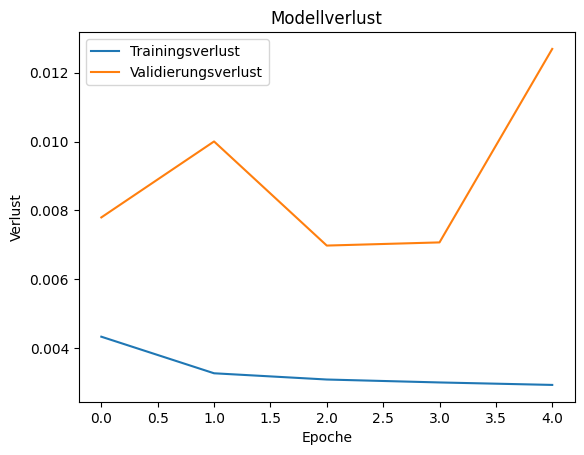

In [ ]:
# Überwachung der Trainingsleistung
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Trainingsverlust')
plt.plot(history.history['val_loss'], label='Validierungsverlust')
plt.title('Modellverlust')
plt.ylabel('Verlust')
plt.xlabel('Epoche')
plt.legend()
plt.show()

In [ ]:
# Angenommen, Sie haben Testdaten: X_test und y_test
test_loss = model.evaluate(X_test, y_test)

563/563 [==============================] - 4s 7ms/step - loss: 0.0070


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
test_loss, test_metric = model.evaluate(X_test, y_test)

print("Testverlust:", test_loss)
print("Testmetrik:", test_metric)  # z.B. Genauigkeit

563/563 [==============================] - 6s 8ms/step - loss: 0.0070 - accuracy: 0.0033
Testverlust: 0.007049506530165672
Testmetrik: 0.0033327778801321983


563/563 [==============================] - 5s 7ms/step


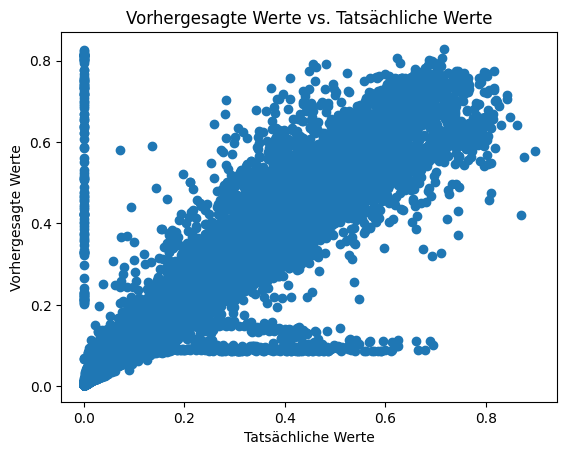

In [ ]:
# Vorhersagen mit dem Testdatensatz
predicted = model.predict(X_test)

# Plotten der Vorhersagen gegen die tatsächlichen Werte
plt.scatter(y_test, predicted)
plt.xlabel("Tatsächliche Werte")
plt.ylabel("Vorhergesagte Werte")
plt.title("Vorhergesagte Werte vs. Tatsächliche Werte")
plt.show()

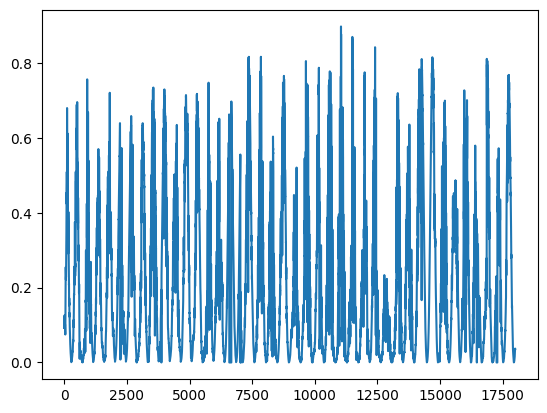

In [ ]:
plt.plot(y_test)

In [ ]:
predicted, y_test

(array([[0.15645605],
        [0.15625085],
        [0.15599678],
        ...,
        [0.05056442],
        [0.05007456],
        [0.05123916]], dtype=float32),
 array([0.09246179, 0.09492652, 0.09832911, ..., 0.03678404, 0.03708798,
        0.03657019]))

In [ ]:
def evaluate_regression(predicted, actual):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    return mse, mae

In [ ]:
# Verwendung der Funktion
mse, mae = evaluate_regression(predicted, y_test)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 0.007049505810255998
Mean Absolute Error: 0.041975299646037884


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Berechnung des MAPE
mape = mean_absolute_percentage_error(y_test, predicted)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

<ipython-input-49-199972fad748>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Mean Absolute Percentage Error (MAPE): inf %


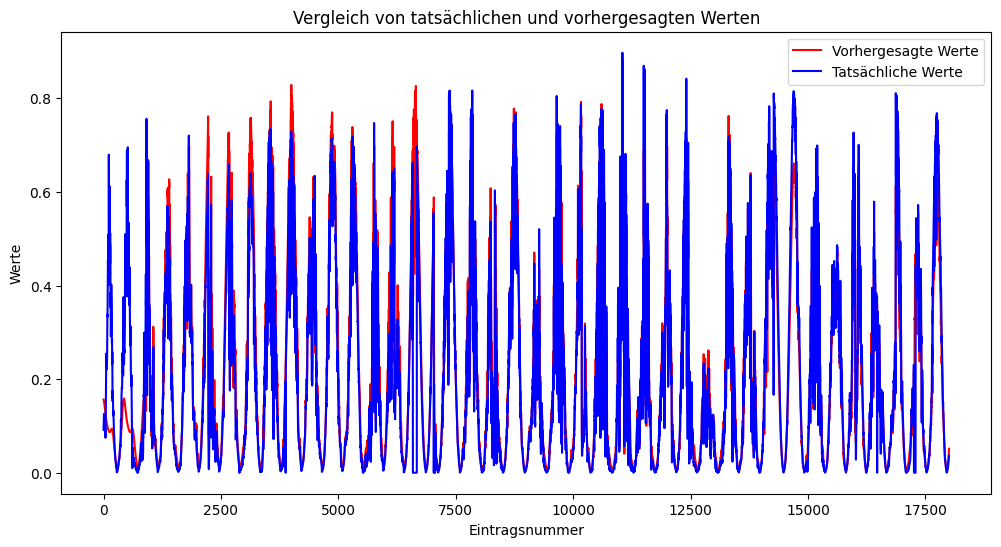

In [ ]:
# Erstellen des Plots
plt.figure(figsize=(12, 6))

# Plotten der vorhergesagten Werte
plt.plot(predicted, label='Vorhergesagte Werte', color='red')

# Plotten der tatsächlichen Werte
plt.plot(y_test, label='Tatsächliche Werte', color='blue')

# Hinzufügen von Titel, Legende und Achsenbeschriftungen
plt.title('Vergleich von tatsächlichen und vorhergesagten Werten')
plt.xlabel('Eintragsnummer')
plt.ylabel('Werte')
plt.legend()

# Anzeigen des Plots
plt.show()